In [1]:
%load_ext autoreload
%autoreload 2

## Imports


In [34]:
import pandas as pd

import logging
import sys
import os
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

logger = logging.getLogger(__name__)
filename_ = os.path.basename(globals()["__vsc_ipynb_file__"])
logging.basicConfig(
    handlers=[
        logging.StreamHandler(sys.stdout),
        logging.FileHandler(filename="../logs/logs.log", mode="w"),
    ],
    level=logging.INFO,
    format=f"%(asctime)s - {filename_} - %(name)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    force=True,
)

# Custom configs
from src.configs import config, config_test
from src.models import EnsembleModel

config = config_test.copy()
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine, load_breast_cancer, load_diabetes


# data = load_wine() # classification (multi)
data = load_breast_cancer()  # classification (binary)
# data = load_diabetes() # regression
if ("wine" in data.filename) or ("breast_cancer" in data.filename):
    task = "classification"
    logger.info(f"{len(set(data.target))=}")
elif "diabetes" in data.filename:
    task = "regression"

2024-04-20 15:30:35 - v3.ipynb - __main__ - INFO - len(set(data.target))=2


In [35]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)
logger.info("Data loaded")

2024-04-20 15:30:41 - v3.ipynb - __main__ - INFO - Data loaded


In [36]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y if task == "classification" else None,
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val,
    y_val,
    test_size=0.5,
    random_state=42,
    stratify=y_val if task == "classification" else None,
)
sets_ = {"train": (X_train, y_train), "val": (X_val, y_val), "test": (X_test, y_test)}

logger.info(f"{X_train.shape=}, {X_val.shape=}, {X_test.shape=}")

2024-04-20 15:30:42 - v3.ipynb - __main__ - INFO - X_train.shape=(398, 30), X_val.shape=(85, 30), X_test.shape=(86, 30)


In [37]:
model = EnsembleModel(config=config, task=task, datasets_=sets_)

2024-04-20 15:30:42 - v3.ipynb - src.utils - INFO - Filling model parameters
2024-04-20 15:30:42 - v3.ipynb - src.utils - INFO - Filled data
2024-04-20 15:30:42 - v3.ipynb - src.utils - INFO - Filled classification parameters


2024-04-20 15:30:42 - v3.ipynb - src.utils - INFO - Model parameters filled


In [38]:
model.train()

2024-04-20 15:30:42 - v3.ipynb - src.models - INFO - Training ensemble
2024-04-20 15:30:42 - v3.ipynb - src.models - INFO - Training base models
2024-04-20 15:30:42 - v3.ipynb - src.models - INFO - xgboost trained
2024-04-20 15:30:42 - v3.ipynb - src.models - INFO - lightgbm trained
2024-04-20 15:30:42 - v3.ipynb - src.models - INFO - catboost trained
2024-04-20 15:30:42 - v3.ipynb - src.models - INFO - Getting meta features
2024-04-20 15:30:42 - v3.ipynb - src.models - INFO - train meta features created
2024-04-20 15:30:42 - v3.ipynb - src.models - INFO - val meta features created
2024-04-20 15:30:42 - v3.ipynb - src.models - INFO - test meta features created
2024-04-20 15:30:42 - v3.ipynb - src.models - INFO - Ensemble trained


2024-04-20 15:30:43 - v3.ipynb - src.utils - INFO - Evaluating model


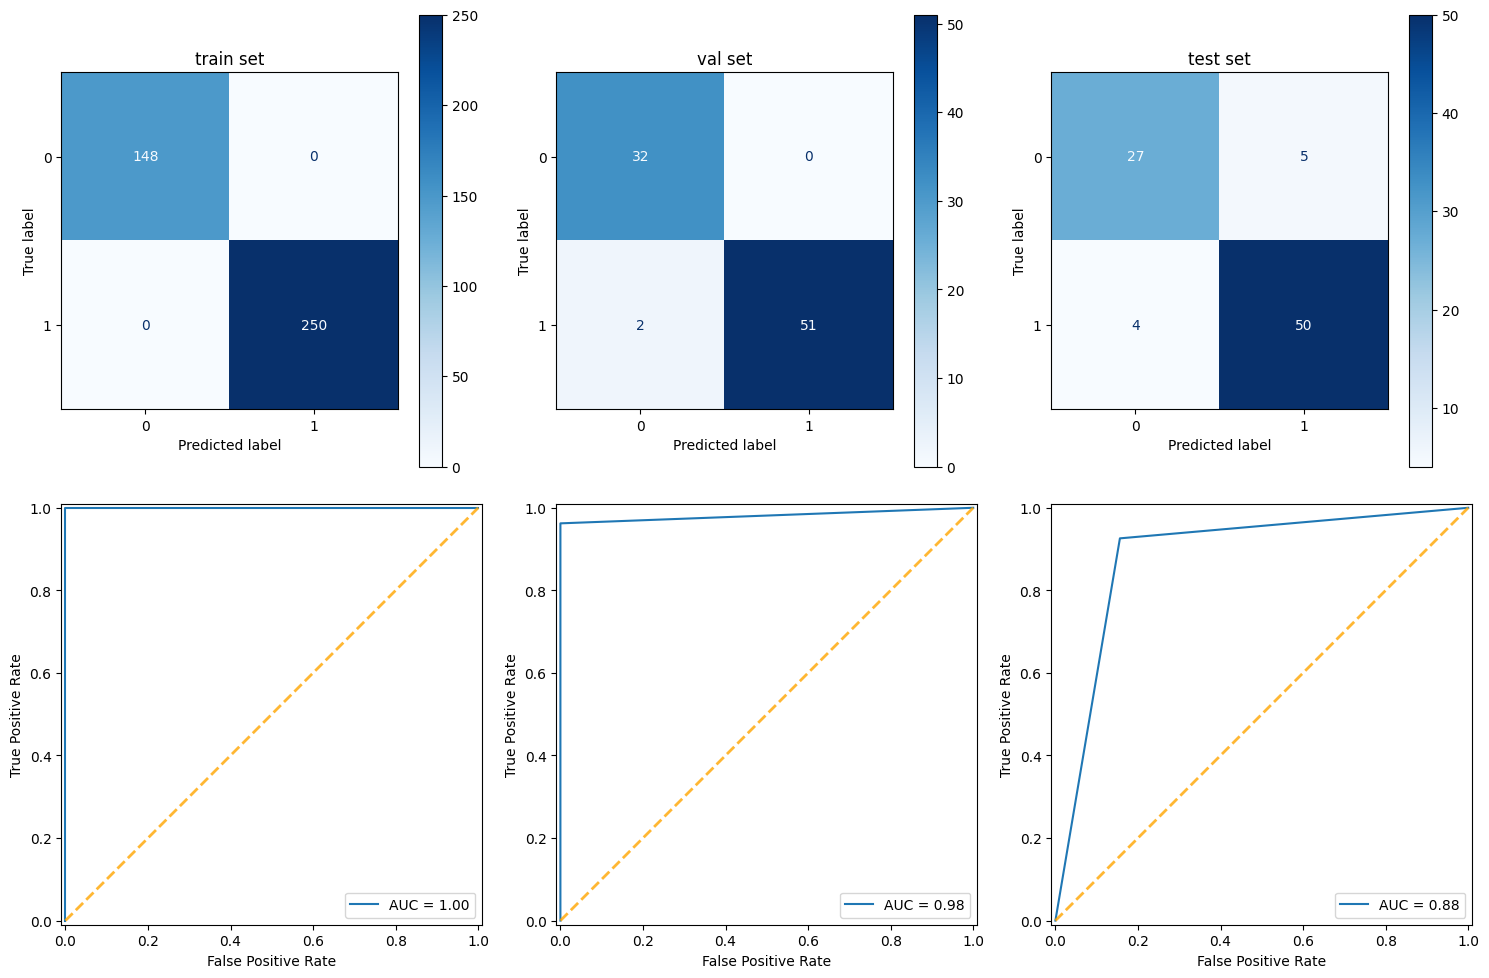

2024-04-20 15:30:43 - v3.ipynb - src.models - INFO - Model evaluation complete. Results saved in model.eval_results


In [39]:
model.evaluate()

In [43]:
from src.configs import hpo_spaces
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.early_stop import no_progress_loss
import numpy as np

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

In [44]:
# curr_basemodel = model.models[0]
# model_name_ = curr_basemodel.__name__
# search_space_ = hpo_spaces[model_name_]
# conf_params = model.config['params'][task][model_name_]
# conf_train_params = model.config['train_params'][model_name_]

In [45]:
# # Move objective from model.config["params"][task][model_name_]
# # Into the search space. Drop the objective from the model.config["params"][task][model_name_]
# search_space_["objective"] = conf_params["objective"]
# del conf_params["objective"]

In [46]:
# Get model.config["params"][task][model_name_] without the objective
# {k: v for k, v in model.config["params"][task][model_name_].items() if k != "objective"}

In [47]:
def get_hpo_objective(model_name, config, task):
    hpo_base_params = {
        "nfold": 5,
        "num_boost_round": 10,
        "early_stopping_rounds": 3,
    }
    if model_name == "xgboost":

        def objective(space):
            results = xgb.cv(
                space,
                dtrain=config["train_params"][model_name]["dtrain"],
                metrics=[config["params"][task][model_name]["eval_metric"]],
                **hpo_base_params,
            )
            best_score = results[
                f"test-{config['params'][task][model_name]['eval_metric']}-mean"
            ].max()
            return {"loss": -best_score, "status": STATUS_OK}

    elif model_name == "lightgbm":

        def objective(space):
            results = lgb.cv(
                space,
                dtrain=config["train_params"][model_name]["train_set"],
                metrics=[config["params"][task][model_name]["metric"]],
                **hpo_base_params,
            )
            best_score = max(
                results[f"valid {config['params'][task][model_name]['metric']}-mean"]
            )
            return {"loss": -best_score, "status": STATUS_OK}

    elif model_name == "catboost":

        def objective(space):
            results = ctb.cv(
                space,
                dtrain=config["train_params"][model_name]["pool"],
                metrics=[config["params"][task][model_name]["loss_function"]],
                **hpo_base_params,
            )
            best_score = max(
                results[
                    f"test-{config['params'][task][model_name]['eval_metric']}-mean"
                ]
            )
            return {"loss": -best_score, "status": STATUS_OK}

    return objective

In [48]:
model_name = model.models[0].__name__
print(model_name)
objective = get_hpo_objective(model_name, model.config, model.task)

xgboost


In [49]:
hpo_spaces[model_name]

{'max_depth': <hyperopt.pyll.base.Apply at 0x17bd5ade0>,
 'eta': <hyperopt.pyll.base.Apply at 0x17bd5b290>,
 'gamma': <hyperopt.pyll.base.Apply at 0x17bd5b3b0>,
 'reg_alpha': <hyperopt.pyll.base.Apply at 0x17bd5b4d0>,
 'reg_lambda': <hyperopt.pyll.base.Apply at 0x17bd5b5f0>,
 'colsample_bytree': <hyperopt.pyll.base.Apply at 0x17bd5b710>,
 'colsample_bynode': <hyperopt.pyll.base.Apply at 0x17bd5b830>,
 'colsample_bylevel': <hyperopt.pyll.base.Apply at 0x17bd5b950>,
 'min_child_weight': <hyperopt.pyll.base.Apply at 0x17bd5ba40>,
 'max_delta_step': <hyperopt.pyll.base.Apply at 0x17bd5bce0>,
 'subsample': <hyperopt.pyll.base.Apply at 0x17bd5bfb0>,
 'seed': 42}

In [50]:
model.config["train_params"][model_name]

{'dtrain': <xgboost.core.DMatrix at 0x32db527b0>,
 'evals': [(<xgboost.core.DMatrix at 0x32db527b0>, 'train'),
  (<xgboost.core.DMatrix at 0x32db51d00>, 'val')],
 'num_boost_round': 10,
 'early_stopping_rounds': 2,
 'verbose_eval': 0}

In [51]:
model.config["params"][task][model_name]

{'objective': 'multi:softprob', 'eval_metric': 'mlogloss', 'num_class': 2}

In [52]:
trials = Trials()
# logger.info(f"Hyperopt for {model_name}")
best_hyperparams = fmin(
    trials=trials,
    fn=objective,
    space=hpo_spaces[model_name],
    algo=tpe.suggest,
    max_evals=20,
    return_argmin=False,
    early_stop_fn=no_progress_loss(10),
    verbose=0,
)
best_params = best_hyperparams.copy()
# `eval_metric` is a key that is not a hyperparameter of the classifier
if "eval_metric" in best_params:
    best_params = {key: best_params[key] for key in best_params if key != "eval_metric"}
# logger.info(f"Hyperopt for {model_name} done")

2024-04-20 14:54:48 - v3.ipynb - hyperopt.tpe - INFO - build_posterior_wrapper took 0.002466 seconds
2024-04-20 14:54:48 - v3.ipynb - hyperopt.tpe - INFO - TPE using 0 trials


2024-04-20 14:54:48 - v3.ipynb - hyperopt.fmin - ERROR - job exception: [14:54:48] /Users/runner/work/xgboost/xgboost/src/metric/multiclass_metric.cu:35: Check failed: label_error >= 0 && label_error < static_cast<int32_t>(n_class): MultiClassEvaluation: label must be in [0, num_class), num_class=1 but found 1 in label
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000017ccf0994 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000017ce732b8 xgboost::metric::MultiClassMetricsReduction<xgboost::metric::EvalMultiLogLoss>::CheckLabelError(int, unsigned long) const + 204
  [bt] (2) 3   libxgboost.dylib                    0x000000017ce73158 xgboost::metric::MultiClassMetricsReduction<xgboost::metric::EvalMultiLogLoss>::CpuReduceMetrics(xgboost::HostDeviceVector<float> const&, xgboost::HostDeviceVector<float> const&, xgboost::HostDeviceVector<float> const&, unsigned long, int) const + 568
  [bt] (3) 4   libxgboost.dy

XGBoostError: [14:54:48] /Users/runner/work/xgboost/xgboost/src/metric/multiclass_metric.cu:35: Check failed: label_error >= 0 && label_error < static_cast<int32_t>(n_class): MultiClassEvaluation: label must be in [0, num_class), num_class=1 but found 1 in label
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x000000017ccf0994 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x000000017ce732b8 xgboost::metric::MultiClassMetricsReduction<xgboost::metric::EvalMultiLogLoss>::CheckLabelError(int, unsigned long) const + 204
  [bt] (2) 3   libxgboost.dylib                    0x000000017ce73158 xgboost::metric::MultiClassMetricsReduction<xgboost::metric::EvalMultiLogLoss>::CpuReduceMetrics(xgboost::HostDeviceVector<float> const&, xgboost::HostDeviceVector<float> const&, xgboost::HostDeviceVector<float> const&, unsigned long, int) const + 568
  [bt] (3) 4   libxgboost.dylib                    0x000000017ce72e70 xgboost::metric::EvalMClassBase<xgboost::metric::EvalMultiLogLoss>::Eval(xgboost::HostDeviceVector<float> const&, xgboost::MetaInfo const&) + 832
  [bt] (4) 5   libxgboost.dylib                    0x000000017ce5efb4 void xgboost::collective::ApplyWithLabels<xgboost::MetricNoCache::Evaluate(xgboost::HostDeviceVector<float> const&, std::__1::shared_ptr<xgboost::DMatrix>)::'lambda'()>(xgboost::MetaInfo const&, void*, unsigned long, xgboost::MetricNoCache::Evaluate(xgboost::HostDeviceVector<float> const&, std::__1::shared_ptr<xgboost::DMatrix>)::'lambda'()&&) + 380
  [bt] (5) 6   libxgboost.dylib                    0x000000017ce5e570 xgboost::MetricNoCache::Evaluate(xgboost::HostDeviceVector<float> const&, std::__1::shared_ptr<xgboost::DMatrix>) + 72
  [bt] (6) 7   libxgboost.dylib                    0x000000017ce39084 xgboost::LearnerImpl::EvalOneIter(int, std::__1::vector<std::__1::shared_ptr<xgboost::DMatrix>, std::__1::allocator<std::__1::shared_ptr<xgboost::DMatrix>>> const&, std::__1::vector<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, std::__1::allocator<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>>> const&) + 1716
  [bt] (7) 8   libxgboost.dylib                    0x000000017cd11624 XGBoosterEvalOneIter + 236
  [bt] (8) 9   libffi.dylib                        0x000000019d230050 ffi_call_SYSV + 80



In [ ]:
# def objective(space):
#     dtrain = xgb.DMatrix(X, y)
#     results = xgb.cv(
#         space,
#         dtrain=dtrain,
#         metrics=["mlogloss"],
#         **self.hpo_params,
#     )

#     best_score = results["test-mlogloss-mean"].max()
#     return {"loss": -best_score, "status": STATUS_OK}

In [ ]:
# def objective(space):
#     metric_ = "multi_logloss" if self.n_classes > 2 else "binary_logloss"
#     results = lgb.cv(
#         space,
#         lgb.Dataset(X, label=y),
#         callbacks=[
#             lgb.early_stopping(
#                 stopping_rounds=self.hpo_params["early_stopping_rounds"],
#                 verbose=False,
#             )
#         ],
#         metrics=[metric_],
#         **{key: self.hpo_params[key] for key in self.hpo_params if key not in ["early_stopping_rounds"]},
#     )
#     best_score = max(results[f"valid {metric_}-mean"])
#     return {"loss": -best_score, "status": STATUS_OK}

In [12]:
# def objective(space):
#                 results = ctb.cv(
#                     ctb.Pool(X, label=y),
#                     space,
#                     logging_level="Silent",
#                     **self.hpo_params,
#                 )
#                 best_score = max(results["test-Logloss-mean"])
#                 return {"loss": -best_score, "status": STATUS_OK}

In [ ]:
# def objective(space):
#     results = curr_basemodel.cv(
#         hpo_spaces[model_name_],
#         model.config["train_params"][model_name_].get(
#             "dtrain",
#             model.config["train_params"][model_name_].get(
#                 "train_set", model.config["train_params"][model_name_].get("pool")
#             ),
#         ),
#         **{k: v for k, v in model.config["params"][task][model_name_].items() if k != "objective"},
#     )
#     logger.info(f"{results=}")
#     metric_used = model.config["params"][task][model_name_].get(
#     "eval_metric",
#     model.config["train_params"][model_name_].get(
#         "metric", model.config["train_params"][model_name_].get("loss_function")
#     ))

#     metric_col = f"test-{metric_used}-mean" if model_name_ == "xgboost" else f"valid-{metric_used}-mean" if model_name_ == "lightgbm" else f"test-{metric_used}-mean"

#     best_score = results[metric_col].max()
#     return {"loss": -best_score, "status": STATUS_OK}